In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
from scipy.optimize import leastsq,curve_fit

In [2]:
#analysis_master_path='Y:/Rb/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\

exp_id='2018_02_22_19_51_37_Red Horizontal alignment with AOM'
data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
exp_path=data_master_path+exp_date+'/'+exp_id+'/'
experiment_file='results.hdf5'
dp=exp_path
cuts = [[450],[450],[450]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
for r in range(5):
    q.set_thresholds(cuts, roi=r)

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [3]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
q.get_thresholds()
retention = q.apply_thresholds()
#np.squeeze(retention['retention'])

In [4]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	150.00	retention:0.441 +- 0.009
ivar:	150.00	retention:0.015 +- 0.009
ivar:	150.00	retention:0.000 +- 0.009
ivar:	150.00	retention:0.000 +- 0.009
ivar:	150.00	retention:0.036 +- 0.009
ivar:	150.50	retention:0.316 +- 0.004
ivar:	150.50	retention:0.000 +- 0.004
ivar:	150.50	retention:0.000 +- 0.004
ivar:	150.50	retention:0.022 +- 0.004
ivar:	150.50	retention:0.000 +- 0.004
ivar:	151.00	retention:0.308 +- 0.018
ivar:	151.00	retention:0.073 +- 0.018
ivar:	151.00	retention:0.025 +- 0.018
ivar:	151.00	retention:0.022 +- 0.018
ivar:	151.00	retention:0.000 +- 0.018
ivar:	151.50	retention:0.160 +- 0.021
ivar:	151.50	retention:0.083 +- 0.021
ivar:	151.50	retention:0.000 +- 0.021
ivar:	151.50	retention:0.000 +- 0.021
ivar:	151.50	retention:0.000 +- 0.021
ivar:	152.00	retention:0.129 +- 0.033
ivar:	152.00	retention:0.198 +- 0.033
ivar:	152.00	retention:0.000 +- 0.033
ivar:	152.00	retention:0.000 +- 0.033
ivar:	152.00	retention:0.000 +- 0.033
ivar:	152.50	retention:0.033 +- 0.031
ivar:	152.50

In [5]:
def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

<IPython.core.display.Javascript object>


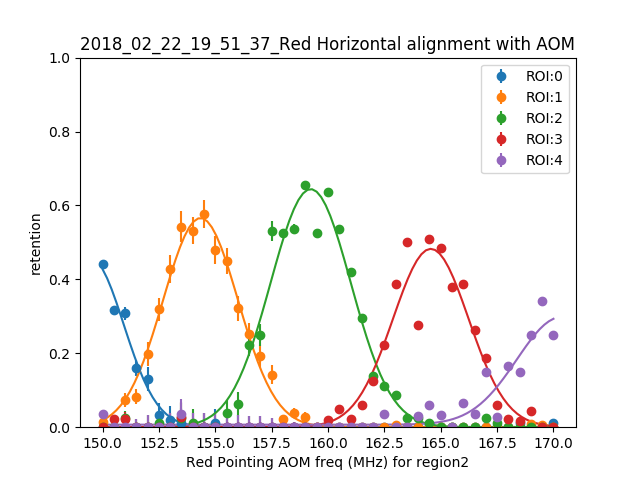

ROI:0, amplitude : 0.456177640192, location: 149.459816053 , sigma:2.09570738815, offset:0.000751504696264
ROI:1, amplitude : 0.565829414933, location: 154.347343647 , sigma:2.35423699008, offset:0.000139013095638
ROI:2, amplitude : 0.644113630352, location: 159.232642993 , sigma:2.51525614649, offset:0.000114455609694
ROI:3, amplitude : 0.481707486478, location: 164.559640135 , sigma:2.37369333845, offset:0.000902887330025
ROI:4, amplitude : 0.291150385497, location: 170.358549603 , sigma:2.80082794512, offset:0.00689612348072


In [6]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
fit_guesses=[0.5,160,2,0]
roi_dependency=[0,5,0,0]
fitted_parameters=[]
for roi in [0,1,2,3,4]:
    
    data = []
    reten = []
    err = []
    for e in range(len(np.squeeze(retention['ivar']))):
        data.append(np.squeeze(retention['ivar'])[e][roi])
        reten.append(np.squeeze(retention['retention'])[e][roi])
        err.append(np.squeeze(retention['error'])[e][roi])
    ax.errorbar(data,reten,yerr=err,label="ROI:{}".format(roi),fmt='o',color=colors[roi])
    guesses=np.add(fit_guesses,np.ones(len(fit_guesses))*(roi-2)*roi_dependency)
    fit = curve_fit(gaussian,data,reten,guesses)
    print "ROI:{}, amplitude : {}, location: {} , sigma:{}, offset:{}".format(roi,fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    fitted_parameters.append(fit[0])
    #print fit[0]
    xarray=np.linspace(np.min(data),np.max(data),100)
    yfit=gaussian(xarray, np.float(fit[0][0]),np.float(fit[0][1]),np.float(fit[0][2]),np.float(fit[0][3]))
    plt.plot(xarray,yfit,color=colors[roi])

plt.show()
ax.set_title(exp_id)
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')
ax.legend()

<IPython.core.display.Javascript object>


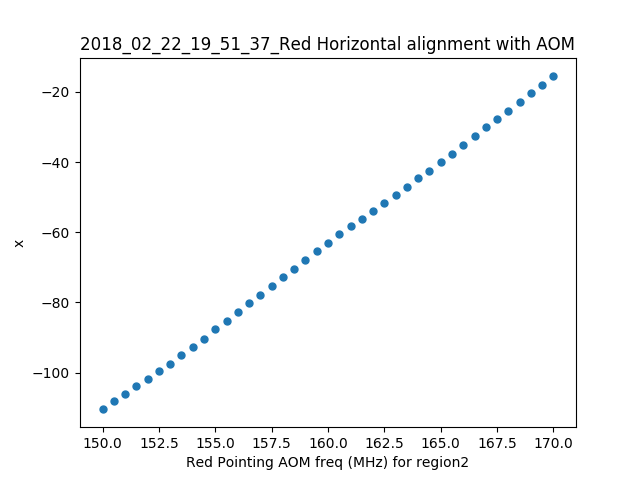

C:\Users\Rb\AppData\Local\Enthought\Canopy\User\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [7]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

<IPython.core.display.Javascript object>


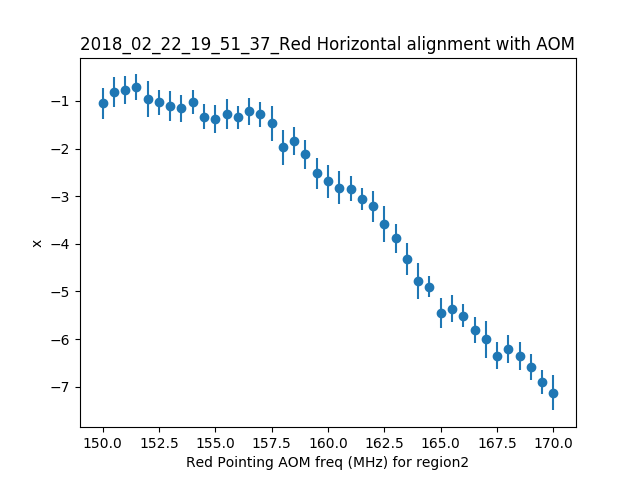

In [8]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_redside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_redside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o')

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

<IPython.core.display.Javascript object>


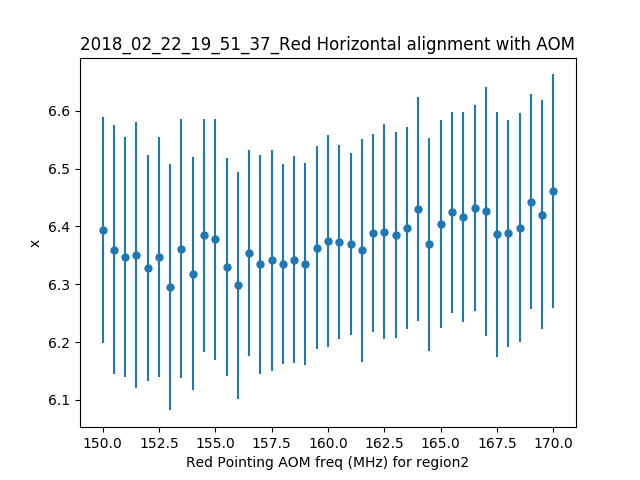

<IPython.core.display.Javascript object>


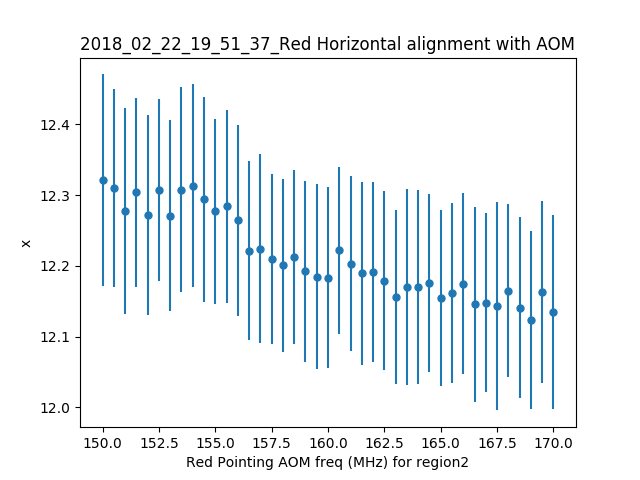

In [10]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['x'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_x'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()

colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig, ax = plt.subplots()
xdata = []
ydata = []
yerr = []
for e in range(len(np.squeeze(retention['ivar']))):
    xdata.append(np.squeeze(retention['ivar'])[e][2])
    ydata.append(q.experiments[0]['iterations'][e]['AAS_blueside']['y'])
    yerr.append(q.experiments[0]['iterations'][e]['AAS_blueside']['sigma_y'])
ax.errorbar(xdata,ydata,yerr=yerr,fmt='o',markersize=5)

plt.show()
ax.set_title(exp_id)
#ax.set_ylim(-10, 10)
ax.set_xlabel(xlab)
ax.set_ylabel('x')
ax.legend()